In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
# 3
#Create image generators for each of the three image data sets (train, validation, test)
#rescale the tensors from values between 0 and 255 to values between 0 and 1.
train_image_generator = ImageDataGenerator(rescale=1./255, dtype='float')
validation_image_generator = ImageDataGenerator(rescale=1./255, dtype='float')
test_image_generator = ImageDataGenerator(rescale=1./255, dtype='float')

#For the *_data_gen variables, use the flow_from_directory method. Pass in the batch size, directory, target size ((IMG_HEIGHT, IMG_WIDTH)), class mode
# For test_data_gen, make sure to pass in shuffle=False to the flow_from_directory method. This will make sure the final predictions stay is in the order that our test expects
train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=128,
        class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=128,
        class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
        PATH,
        classes = ['test'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=128,
        class_mode= 'binary', shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


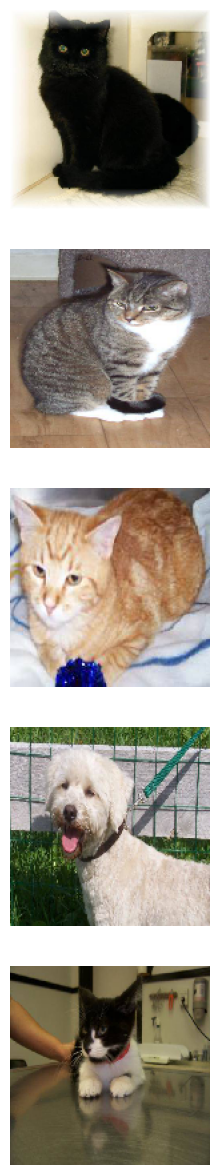

In [ ]:
# 4
#Plotting some images
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# 5
#Since there are a small number of training examples, there is a risk of overfitting. 
#One way to fix this problem is by creating more training data from existing training examples by using random transformations.
#Recreate the train_image_generator using ImageDataGenerator.
#Add 4-6 random transformations as arguments to ImageDataGenerator. Make sure to rescale the same as before
train_image_generator = ImageDataGenerator(rescale=1./255, dtype='float', horizontal_flip= True, zoom_range=0.07 , rotation_range=30, width_shift_range=0.15,height_shift_range=0.15)


Found 2000 images belonging to 2 classes.


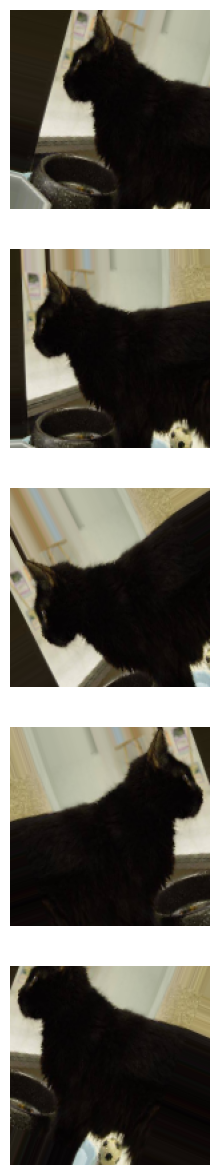

In [ ]:
# 6
#Plot the same imaged but changed
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# 7
#model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # 150x150 RGB images
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 17, 17, 64)      

In [ ]:
# 8
#fitting the model
history = model.fit(train_data_gen, epochs=15, steps_per_epoch=10,
                    validation_data=val_data_gen, validation_steps=1)

Epoch 1/15
10/10 [==============================] - 15s 1s/step - loss: 0.6933 - accuracy: 0.4886 - val_loss: 0.6857 - val_accuracy: 0.5625
Epoch 2/15
10/10 [==============================] - 11s 1s/step - loss: 0.6911 - accuracy: 0.4977 - val_loss: 0.6807 - val_accuracy: 0.5859
Epoch 3/15
10/10 [==============================] - 11s 1s/step - loss: 0.6877 - accuracy: 0.5446 - val_loss: 0.6844 - val_accuracy: 0.4688
Epoch 4/15
10/10 [==============================] - 11s 1s/step - loss: 0.6825 - accuracy: 0.5641 - val_loss: 0.6507 - val_accuracy: 0.6875
Epoch 5/15
10/10 [==============================] - 11s 1s/step - loss: 0.6611 - accuracy: 0.6055 - val_loss: 0.6312 - val_accuracy: 0.6250
Epoch 6/15
10/10 [==============================] - 10s 992ms/step - loss: 0.6757 - accuracy: 0.5739 - val_loss: 0.6876 - val_accuracy: 0.5234
Epoch 7/15
10/10 [==============================] - 11s 1s/step - loss: 0.6656 - accuracy: 0.5844 - val_loss: 0.6299 - val_accuracy: 0.5938
Epoch 8/15
10/10 

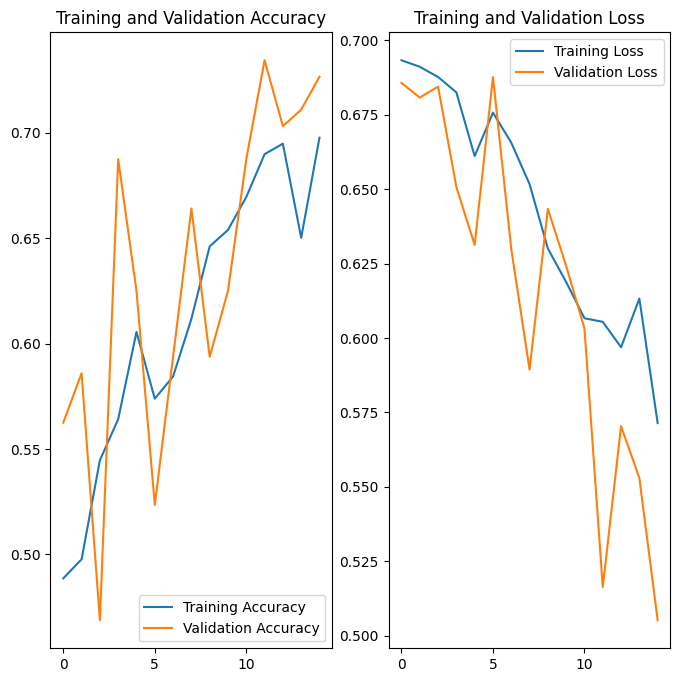

In [ ]:
# 9
#accurancy and lost comparation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 10
#test the model and check if it is okay
probabilities = model.predict(test_data_gen)[:,1]
test, _ = next(test_data_gen)
plotImages(test,probabilities)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 11
#Cell to know if the project passes the test
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
